In [ ]:
 import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
dataset = MNIST(root='data/',download =True,transform = ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


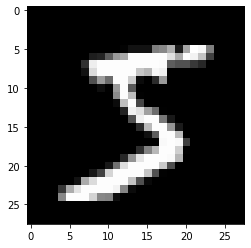

In [ ]:
image,label = dataset[0]
plt.imshow(image[0],cmap='gray')
plt.show()

### Loading train and test dataset

In [ ]:
#Splitting dataset to train and validation
val_size = 10000
train_size = len(dataset) - val_size
train_set,val_set = random_split(dataset,[train_size,val_size])

In [ ]:
#Loading train dataset and splitting to batches
batch_size = 128
train_loader = DataLoader(train_set,batch_size=128,shuffle=True,num_workers=2,pin_memory =True)
val_loader = DataLoader(val_set,batch_size=256,shuffle=True,num_workers=2,pin_memory=True)

## Using RELU

In [ ]:
for images,label in train_loader:
  inputs = images.reshape(-1,784)
  break

In [ ]:
input_shape = inputs.shape[-1]
output_size = 32
layer1 = nn.Linear(input_shape,32)

In [ ]:
output = layer1(inputs)

In [ ]:
output

tensor([[ 0.2589, -0.1921, -0.1585,  ..., -0.0034,  0.2944,  0.1630],
        [-0.0132,  0.1400,  0.0545,  ..., -0.0409,  0.3069,  0.0125],
        [-0.0925,  0.0592, -0.1046,  ..., -0.1069, -0.1960, -0.1440],
        ...,
        [ 0.2064,  0.2005, -0.2028,  ...,  0.0831,  0.2304,  0.1627],
        [ 0.2306, -0.0579, -0.0151,  ...,  0.0723,  0.2282, -0.0608],
        [ 0.1480,  0.0333, -0.0714,  ...,  0.1403,  0.1596, -0.0829]],
       grad_fn=<AddmmBackward>)

Using Relu function on the output found

In [ ]:
out_with_activation = F.relu(output)
out_with_activation

tensor([[0.2589, 0.0000, 0.0000,  ..., 0.0000, 0.2944, 0.1630],
        [0.0000, 0.1400, 0.0545,  ..., 0.0000, 0.3069, 0.0125],
        [0.0000, 0.0592, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2064, 0.2005, 0.0000,  ..., 0.0831, 0.2304, 0.1627],
        [0.2306, 0.0000, 0.0000,  ..., 0.0723, 0.2282, 0.0000],
        [0.1480, 0.0333, 0.0000,  ..., 0.1403, 0.1596, 0.0000]],
       grad_fn=<ReluBackward0>)

### Creating a Model with single Hidden Layer.

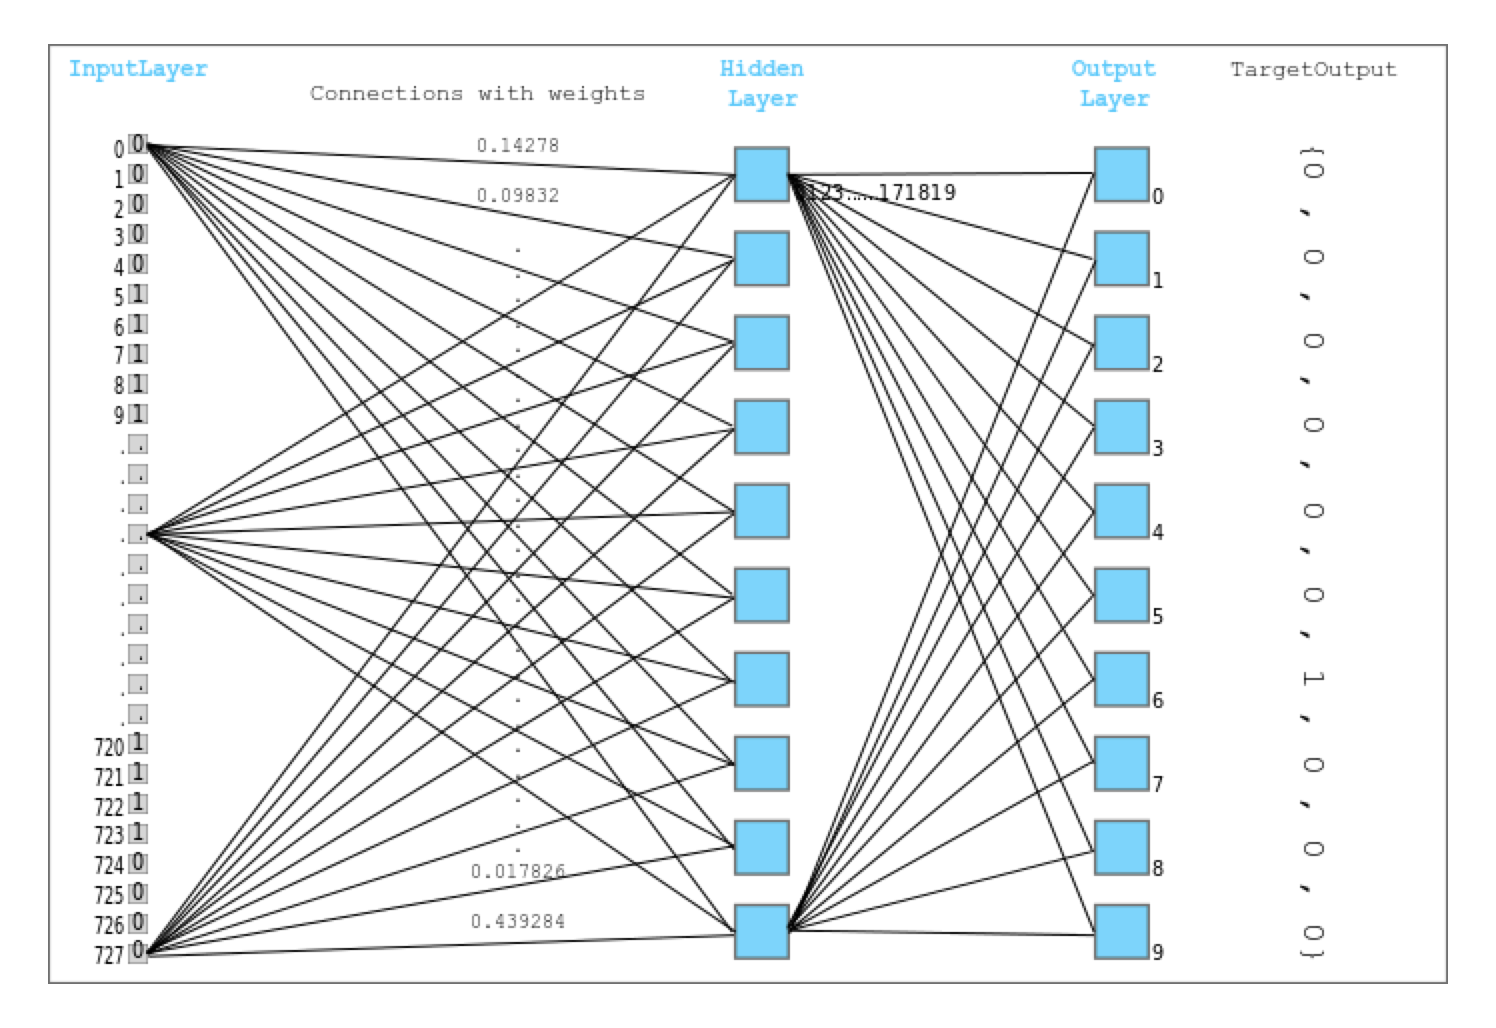

In [ ]:
class Mnistmodel(nn.Module):
  def __init__(self,input_size,hidden_size,out_size):
    super().__init__()
    ##hidden layer 
    self.linear1 = nn.Linear(input_size,hidden_size)
    ## Output layer
    self.linear2 = nn.Linear(hidden_size,out_size)

  def forward(self,xb):
    xb = xb.view(xb.size(0),-1)
    # Output of hidden layer
    out = self.linear1(xb)
    #Applying Relu activation on output of hidden layer
    rel = F.relu(out)
    # Final output
    out  = self.linear2(rel)
    return out
  def training_step(self,batch):
    """ Returns loss for a training data"""
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  
  def validation_step(self,batch):
    """Finding loss and accuracy for a batch of validation data"""
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}
  
  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accuracy = [x['val_acc'] for x in outputs]
    epoch_accuracy = torch.stack(batch_accuracy).mean()
    return {'val_loss':epoch_loss,'val_acc':epoch_accuracy}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

  



In [ ]:
def accuracy(output,labels):
  _,preds =torch.max(output,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))


### Using GPU 

In [ ]:
###Lets check if GPU is available
torch.cuda.is_available()

True

#### Defining a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't.

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

### Moving data to a particular device

In [ ]:
#For moving tensor data/model  to a particualr device the below code can be used
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

##### Creating a DeviceDataLoader class which is a wrap up of the already existing dataloader.This is created to move batches of data to selected device. 

In [ ]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    #By calling yield, each time a batch is returned to the device from the dataloader.
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader,device)
val_loader = DeviceDataLoader(val_loader,device)

In [ ]:
#Example
for image,labels in train_loader:
  x = image
  y = labels
  print(x.device)
  print(y.device)
  break

cuda:0
cuda:0


### Training the Model

In [ ]:
def evaluate(model,val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)
def fit(epochs,lr,model,train_loader,val_loader,opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    #training phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #Validation phase
    result = evaluate(model,val_loader)
    model.epoch_end(epoch,result)# Result after each epoch
    history.append(result)
  return history

We had already set our train_data and test_data on GPU, next we have to set model onto GPU

In [ ]:
num_classes =10
model = Mnistmodel(input_size =784 ,hidden_size=32,out_size= num_classes)
to_device(model,device)

Mnistmodel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
# Calculaitng the performance of the model with inital parameters withhout training.
history = [evaluate(model,val_loader)]
print(history)

[{'val_loss': tensor(2.3093, device='cuda:0', grad_fn=<MeanBackward0>), 'val_acc': tensor(0.0909)}]


In [ ]:
history+= fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2435, val_acc: 0.9313
Epoch [1], val_loss: 0.1978, val_acc: 0.9435
Epoch [2], val_loss: 0.1683, val_acc: 0.9519
Epoch [3], val_loss: 0.1584, val_acc: 0.9538
Epoch [4], val_loss: 0.1379, val_acc: 0.9583


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1267, val_acc: 0.9638
Epoch [1], val_loss: 0.1186, val_acc: 0.9655
Epoch [2], val_loss: 0.1189, val_acc: 0.9651
Epoch [3], val_loss: 0.1250, val_acc: 0.9641
Epoch [4], val_loss: 0.1198, val_acc: 0.9636


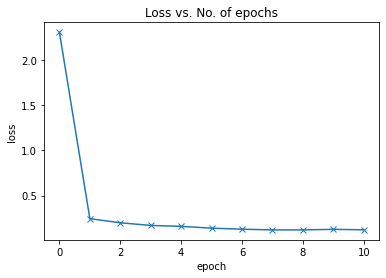

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

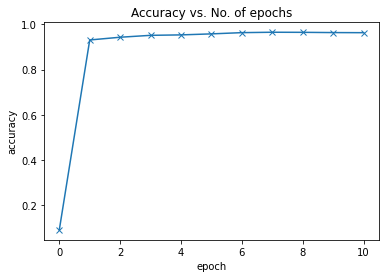

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');